In [21]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.rcParams["text.usetex"] = True
# matplotlib.rcParams["font.family"] = "serif"
# # matplotlib.rcParams["font.size"] = "11"
# sns.set(style='whitegrid', palette='colorblind', color_codes=True, font_scale=1.25)
# # textwidth = 5.9 inches
# textwith = 150  # mm

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

fontsize = 11
textwidth = 5.9  # inches
sns.set_context("paper", font_scale=1.0, rc={'lines.linewidth': 0.75,
                                             'axes.linewidth': 0.75,
                                             'font.size': fontsize,
                                             'axes.labelsize': fontsize,
                                             'xtick.labelsize': fontsize,
                                             'ytick.labelsize': fontsize,
                                             'legend.fontsize': fontsize,
                                             'text.usetex': True
                                             })

In [22]:
# load hospo_respo data

data_dir = Path('../../data/hotel/500k')
scored_data = [
    'trip_hotels.pkl',
    'trip_hotels.gen_sts_scores.pkl',
    'trip_hotels.response_ppl_scores.pkl',
    'trip_hotels.zipf_dist_scores.pkl',
    'trip_hotels.response_tfidf_scores_norm.pkl',
    'trip_hotels.rev_resp_tfidf_scores.pkl',
    'trip_hotels.rev_resp_sts_scores.pkl',
    ]

hospo_data = pd.concat([pd.read_pickle(data_dir / f) for f in scored_data], axis=1)
print(len(hospo_data))
hospo_data.drop(columns=['Unnamed: 0'], inplace=True)
# df.to_csv('../hotel/500k/trip_hotels.scored.csv')
print(hospo_data.columns)

500000
Index(['domain', 'rating', 'review_author', 'response_author', 'review_clean',
       'response_clean', 'sentiment', 'db_internal_id', 'establishment',
       'trip_id', 'trip_url', 'country', 'split',
       'score:review_response_length_ratio', 'score:response_sentence_length',
       'score:genericness_semantic_avg', 'score:genericness_length_ratio',
       'score:review_response_wmd', 'rrgen_id', 'trip_review_url',
       'trip_review_id', 'score:genericness_sent_level_sts_avg',
       'score:response_text_ppl', 'score:response_freq_distro_ratio',
       'score:response_tfidf', 'score:rev_resp_tfidf', 'score:rev_resp_sts'],
      dtype='object')


In [23]:
app_data_train = Path('../../data/apps/rrgen_train_data.txt')
app_data_test = Path('../../data/apps/rrgen_test_data.txt')
app_data_valid = Path('../../data/apps/rrgen_valid_data.txt')
# load csv file with special delimiters (***) and no header and extract the 6th column
app_splits = []
for split in ['train', 'test', 'valid']:
    app_data = Path(f'../../data/apps/rrgen_{split}_data.txt')
    df = pd.read_csv(app_data, sep='\*\*\*', header=None, index_col=False, names=['app', 'rating', 'date', 'unk', 'review', 'response', 'response_date', 'sentiment', 'category'], engine='python')
    df['split'] = split
    app_splits.append(df)

app_data = pd.concat(app_splits)
print(len(app_data))
print(app_data.columns)
print(app_data['split'].value_counts())

# # load apps data from pickle
# app_data = pd.read_pickle('../../data/apps/src-tgt/data.pkl')
# print(len(app_data))
# print(app_data.columns)

308380
Index(['app', 'rating', 'date', 'unk', 'review', 'response', 'response_date',
       'sentiment', 'category', 'split'],
      dtype='object')
train    278374
test      15404
valid     14602
Name: split, dtype: int64


In [24]:
# for each split, get the distribution of ratings
def get_rating_dist(df):
    for split in df['split'].unique():
        print(split)
        split_df = df[df['split'] == split]
        print(split_df['rating'].value_counts(normalize=True).sort_index().to_dict())

    print('all')
    print(df['rating'].value_counts(normalize=True).sort_index().to_dict())

get_rating_dist(app_data)
get_rating_dist(hospo_data)

train
{1: 0.31453009260922354, 2: 0.1026029729787983, 3: 0.1837132778204861, 4: 0.13357210084275112, 5: 0.2655815557487409}
test
{1: 0.31219163853544535, 2: 0.10198649701376265, 3: 0.18079719553362764, 4: 0.13795118151129576, 5: 0.2670734874058686}
valid
{1: 0.31653198192028487, 2: 0.10368442679085056, 3: 0.1792220243802219, 4: 0.13429667168880977, 5: 0.2662648952198329}
all
{1: 0.3145080744535962, 2: 0.10262338673065698, 3: 0.18335495168298852, 4: 0.13382515078798884, 5: 0.26568843634476946}
train
{1: 0.04170376603969651, 2: 0.0518132989317601, 3: 0.11154680516112415, 4: 0.25630208252380837, 5: 0.5386340473436109}
valid
{1: 0.04177210105635217, 2: 0.05173314053902076, 3: 0.11274450737036591, 4: 0.25637627023336146, 5: 0.5373739808008997}
test
{1: 0.04184184993531695, 2: 0.05154430789133247, 3: 0.11153783958602846, 4: 0.25533635187580855, 5: 0.5397396507115135}
all
{1: 0.041714, 2: 0.051796, 3: 0.111606, 4: 0.256258, 5: 0.538626}


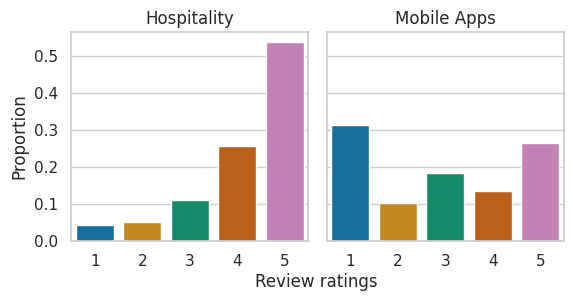

In [93]:
# plot the distribution of ratings

sns.set(style='whitegrid', palette='colorblind')

# plot a single figure with multiple axes for both distributions
fig, ax = plt.subplots(1, 2, figsize=(textwidth, textwidth*0.5), sharey=True)

# plot normalized count of ratings
sns.barplot(x=hospo_data['rating'].value_counts(normalize=True).sort_index().index, y=hospo_data['rating'].value_counts(normalize=True).sort_index().values, ax=ax[0])
ax[0].set_title('Hospitality')
ax[0].set_xlabel('')
ax[0].set_ylabel('Proportion')

# plot normalized count of ratings
sns.barplot(x=app_data['rating'].value_counts(normalize=True).sort_index().index, y=app_data['rating'].value_counts(normalize=True).sort_index().values, ax=ax[1])
ax[1].set_title('Mobile Apps')
ax[1].set_xlabel('')

# shared x label
fig.text(0.55, 0, 'Review ratings', ha='center')

plt.tight_layout()
plt.savefig('/home/user/kew/projects/diss_figs/rrgen_hotel_app_rating_dist.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/home/user/kew/projects/diss_figs/rrgen_hotel_app_rating_dist.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [51]:
# check whether establishments overlap between train, test, validation splits

# get train subset


# get the unique establishments in each split
train_est = set(hospo_data[hospo_data['split'] == 'train']['establishment'].tolist())
test_est = set(hospo_data[hospo_data['split'] == 'test']['establishment'].tolist())
valid_est = set(hospo_data[hospo_data['split'] == 'valid']['establishment'].tolist())

print(len(train_est))
print(len(test_est))
print(len(valid_est))

print(len(train_est.intersection(test_est)))
print(len(train_est.intersection(valid_est)))

7502
4125
4090
4084
4037


In [52]:
from sacremoses import MosesTokenizer
from tqdm import tqdm

tokenizer = MosesTokenizer(lang='en')

def tokenize_text(text):
    """
    Given a text string, return a new string with whitespace delim tokens.
    """
    return tokenizer.tokenize(text, return_str=True).lower()

# tokenize the hospo reviews
hospo_data['review_tokens'] = list(tqdm(map(tokenize_text, hospo_data['review_clean'].tolist()), total=len(hospo_data)))
hospo_data['response_tokens'] = list(tqdm(map(tokenize_text, hospo_data['response_clean'].tolist()), total=len(hospo_data)))


100%|██████████| 500000/500000 [05:55<00:00, 1407.48it/s]


In [56]:
# plot the distribution of review lengths between the two datasets
app_data['review_len'] = app_data['review'].apply(lambda x: len(x.split()))
hospo_data['review_len'] = hospo_data['review_tokens'].apply(lambda x: len(x.split()))
app_data['response_len'] = app_data['response'].apply(lambda x: len(x.split()))
hospo_data['response_len'] = hospo_data['response_tokens'].apply(lambda x: len(x.split()))

# save the dataframes for later use
hospo_data.to_pickle('/srv/scratch1/kew/diss_data/hospo_data_scored.pkl')
app_data.to_pickle('/srv/scratch1/kew/diss_data/app_data_original.pkl')

In [74]:
# sample hospo data to match app data
hospo_data_sample = hospo_data.sample(n=len(app_data), random_state=42)

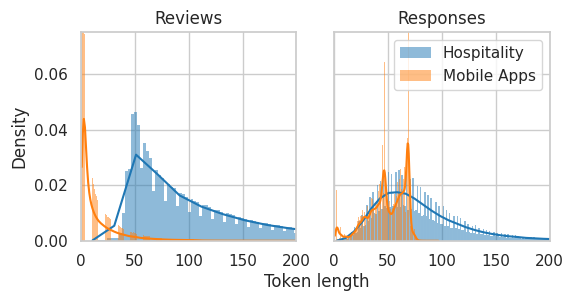

In [92]:

sns.set(style='whitegrid', palette='colorblind')

# plot a single figure with multiple axes for both distributions
fig, ax = plt.subplots(1, 2, figsize=(textwidth, textwidth*0.5), sharey=True)

colormap = plt.cm.get_cmap('tab10', 10)


# plot distribution of review lengths
sns.histplot(hospo_data_sample['review_len'], kde=True, stat='probability', ax=ax[0], label='Hospitality', color=colormap(0))
sns.histplot(app_data['review_len'], kde=True, stat='probability', ax=ax[0], label='Mobile Apps', color=colormap(1))

ax[0].set_title('Reviews')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('')
ax[0].set_xlim(0, 200)
ax[0].set_ylim(0, 0.075)

# plot distribution of response lengths
sns.histplot(hospo_data_sample['response_len'], kde=True, stat='probability',  ax=ax[1], label='Hospitality', color=colormap(0))
sns.histplot(app_data['response_len'], kde=True, stat='probability', ax=ax[1], label='Mobile Apps', color=colormap(1))
ax[1].set_title('Responses')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('')
ax[1].set_xlim(0, 200)

# x-axis label shared
fig.text(0.55, 0, 'Token length', ha='center')


# legend
plt.legend(loc='upper right')

# ensure that figsize matches the textwidth
plt.tight_layout()

plt.savefig('/home/user/kew/projects/diss_figs/rrgen_hotel_app_token_lengths.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/home/user/kew/projects/diss_figs/rrgen_hotel_app_token_lengths.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [97]:
# number of tokens in the reviews and responses
# for split in ['train', 'test', 'valid']:
#     print(split)
#     split_df = hospo_data[hospo_data['split'] == split]
#     print(split_df['review_len'].describe())
#     print(split_df['response_len'].describe())

# print('all')
print(hospo_data['review_len'].describe())
print(hospo_data['response_len'].describe())

print(app_data['review_len'].describe())
print(app_data['response_len'].describe())

count    500000.000000
mean        126.833678
std         111.515187
min           8.000000
25%          59.000000
50%          90.000000
75%         152.000000
max        4027.000000
Name: review_len, dtype: float64
count    500000.000000
mean         80.759382
std          50.260032
min           3.000000
25%          50.000000
50%          70.000000
75%          98.000000
max        1588.000000
Name: response_len, dtype: float64
count    308380.000000
mean         16.031121
std          21.290605
min           1.000000
25%           3.000000
50%           7.000000
75%          20.000000
max         200.000000
Name: review_len, dtype: float64
count    308380.000000
mean         48.909971
std          17.089620
min           1.000000
25%          38.000000
50%          49.000000
75%          64.000000
max          97.000000
Name: response_len, dtype: float64


In [99]:
# count the number of sentences in each review

from nltk.tokenize import sent_tokenize

hospo_data['review_sents'] = list(tqdm(map(sent_tokenize, hospo_data['review_clean'].tolist()), total=len(hospo_data)))


100%|██████████| 500000/500000 [01:20<00:00, 6244.85it/s]


In [101]:
hospo_data['response_sents'] = list(tqdm(map(sent_tokenize, hospo_data['response_clean'].tolist()), total=len(hospo_data)))

100%|██████████| 500000/500000 [00:52<00:00, 9533.13it/s] 


In [102]:
hospo_data['review_sent_len'] = hospo_data['review_sents'].apply(lambda x: len(x))
hospo_data['response_sent_len'] = hospo_data['response_sents'].apply(lambda x: len(x))

print(hospo_data['review_sent_len'].describe())
print(hospo_data['response_sent_len'].describe())

count    500000.000000
mean          7.363910
std           5.612717
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max         252.000000
Name: review_sent_len, dtype: float64
count    500000.000000
mean          4.684288
std           2.092976
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          75.000000
Name: response_sent_len, dtype: float64


In [104]:
app_data['review_sents'] = list(tqdm(map(sent_tokenize, app_data['review'].tolist()), total=len(app_data)))
app_data['response_sents'] = list(tqdm(map(sent_tokenize, app_data['response'].tolist()), total=len(app_data)))
print(app_data['review_sents'].head())

app_data['review_sent_len'] = app_data['review_sents'].apply(lambda x: len(x))
app_data['response_sent_len'] = app_data['response_sents'].apply(lambda x: len(x))

print(app_data['review_sent_len'].describe())
print(app_data['response_sent_len'].describe())


100%|██████████| 308380/308380 [00:23<00:00, 12934.40it/s]


0               [its only support in iphone i think .]
1    [this be great app but can you add feature to ...
2                                               [ok .]
3                                         [its good .]
4                                    [i jst hate it .]
Name: review_sents, dtype: object
count    308380.000000
mean          1.755720
std           1.569973
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          58.000000
Name: review_sent_len, dtype: float64
count    308380.000000
mean          4.420264
std           1.751635
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max          17.000000
Name: response_sent_len, dtype: float64


In [107]:
# total number of sents in the reviews and responses

for split in ['train', 'test', 'valid']:
    print(split)
    split_df = hospo_data[hospo_data['split'] == split]
    print(split_df['review_sent_len'].sum() + split_df['response_sent_len'].sum())

for split in ['train', 'test', 'valid']:
    print(split)
    split_df = app_data[app_data['split'] == split]
    print(split_df['review_sent_len'].sum() + split_df['response_sent_len'].sum())


train
5426477
test
297922
valid
299700
train
1719229
test
95104
valid
90217
